In [1]:
import torch
import spacy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset, load_metric, Dataset, concatenate_datasets
from transformers import DataCollatorForTokenClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import AutoModelForTokenClassification, AutoTokenizer
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix

/user/HS225/os00315/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
2024-05-03 08:16:11.868697: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 08:16:15.137493: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/user/HS225/os00315/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
dataset = load_dataset("surrey-nlp/PLOD-CW")
dataset2 = load_dataset("surrey-nlp/PLOD-filtered")

In [4]:
reverse_encoding = {0: "B-O", 1: "B-AC", 3: "B-LF", 4: "I-LF"}

In [5]:
# Returns samples from additional dataset that are not in the original dataset
def new_dict(dataset, subset, size):
    train2 = dataset2[subset][:2500]
    temp_tokens, temp_pos, temp_ner = [], [], []

    for tokens, pos_tags, ner_tags in zip(train2['tokens'], train2['pos_tags'], train2['ner_tags']):
        if tokens not in dataset['tokens']:
            temp_tokens.append(tokens)
            temp_pos.append(pos_tags)
            temp_ner.append(ner_tags)
        if len(temp_tokens) == int(len(dataset['tokens']) * size):
            break

    # Change additional dataset numeric encoding to NER tags
    for i, tags in enumerate(temp_ner):
        temp_ner[i] = [reverse_encoding[tag] for tag in tags]
    for i, tags in enumerate(temp_pos): # Fill additional dataset numeric pos_tags with filler strings
        temp_pos[i] = ['O' for tag in tags]

    # print('size', len(temp_tokens))
    return {'tokens':temp_tokens, 'pos_tags':temp_pos, 'ner_tags':temp_ner}

In [6]:
# Add new sample to train dataset
new_train = new_dict(dataset['train'], 'train', 2)
new_data_train = Dataset.from_dict(new_train)
dataset['train'] = concatenate_datasets([dataset['train'], new_data_train])

In [7]:
new_val = new_dict(dataset['validation'], 'validation', 2)
new_data_val = Dataset.from_dict(new_val)
dataset['validation'] = concatenate_datasets([dataset['validation'], new_data_val])

In [8]:
eng = spacy.load("en_core_web_sm")

def lemmatize_tokens(dataset):       
    dataset['tokens'] = [eng(token)[0].lemma_ for token in dataset['tokens']]
    return dataset

In [9]:
dataset = dataset.map(lambda dataset: lemmatize_tokens(dataset))

In [10]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [11]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [12]:
model = AutoModelForTokenClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

In [14]:
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

label_list = []
for sample in train_dataset["ner_tags"]:
    label_list.append([label_encoding[tag] for tag in sample])

val_label_list = []
for sample in val_dataset["ner_tags"]:
    val_label_list.append([label_encoding[tag] for tag in sample])

test_label_list = []
for sample in test_dataset["ner_tags"]:
    test_label_list.append([label_encoding[tag] for tag in sample])

In [15]:
def tokenize_and_align_labels(dataset, list_name):
    tokenized_inputs = tokenizer(dataset["tokens"], truncation=True, is_split_into_words=True, max_length=512) ## For some models, you may need to set max_length to approximately 500.

    labels = []
    for i, label in enumerate(list_name):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [16]:
tokenized_datasets = tokenize_and_align_labels(train_dataset, label_list)
tokenized_val_datasets = tokenize_and_align_labels(val_dataset, val_label_list)
tokenized_test_datasets = tokenize_and_align_labels(test_dataset, test_label_list)

In [17]:
def turn_dict_to_list_of_dict(d):
    new_list = []

    for labels, inputs in zip(d["labels"], d["input_ids"]):
        entry = {"input_ids": inputs, "labels": labels}
        new_list.append(entry)

    return new_list

In [18]:
tokenised_train = turn_dict_to_list_of_dict(tokenized_datasets)
tokenised_val = turn_dict_to_list_of_dict(tokenized_val_datasets)
tokenised_test = turn_dict_to_list_of_dict(tokenized_test_datasets)

In [19]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [20]:
metric = load_metric("seqeval")
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

/tmp/ipykernel_1602476/1580341719.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/user/HS225/os00315/.local/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [21]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
# Training arguments (feel free to play arround with these values)
epochs = 6
batch_size = 4
learning_rate = 2e-5

args = TrainingArguments(
    f"DistilBERT-finetuned-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    args,
    train_dataset=tokenised_train,
    eval_dataset=tokenised_val,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

/user/HS225/os00315/.local/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [22]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


TrainOutput(global_step=4824, training_loss=0.1587639028950908, metrics={'train_runtime': 339.7409, 'train_samples_per_second': 56.796, 'train_steps_per_second': 14.199, 'total_flos': 490237345407840.0, 'train_loss': 0.1587639028950908, 'epoch': 6.0})

/user/HS225/os00315/.local/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [0, 0, 0, 0, 2, 3, 3, 3, 3, 0, 1, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/user/HS225/os00315/.local/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/user/HS225/os00315/.local/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/user/HS225/os00315/.local/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [1, 0, 2, 

              precision    recall  f1-score   support

         B-O       0.97      0.96      0.96      5384
        B-AC       0.81      0.80      0.80       540
        B-LF       0.75      0.81      0.78       301
        I-LF       0.79      0.87      0.83       406

    accuracy                           0.93      6631
   macro avg       0.83      0.86      0.84      6631
weighted avg       0.93      0.93      0.93      6631

Overall F1 Score: 0.8421664128882109
Overall Precision Score: 0.8272316827040417
Overall Recall Score: 0.8586963422624134


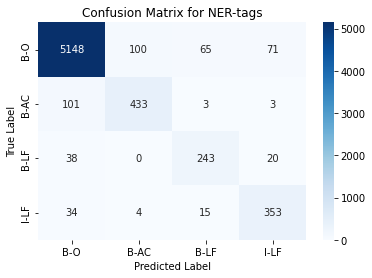

In [23]:
predictions, labels, _ = trainer.predict(tokenised_test)
predictions = np.argmax(predictions, axis=2)

# Remove the predictions for the [CLS] and [SEP] tokens
y_pred = []
y_true = []

for prediction, label in zip(predictions, labels):
    filtered_pairs = [(p, l) for p, l in zip(prediction, label) if l != -100]
    y_pred.extend([p for p, _ in filtered_pairs])
    y_true.extend([l for _, l in filtered_pairs])

# Compute multiple metrics on the test restuls
labels_indices = list(label_encoding.values())
labels_names = list(label_encoding.keys())
print(classification_report(y_true, y_pred, labels=labels_indices, target_names=labels_names))

overall_f1 = f1_score(y_true, y_pred, average= 'macro')
overall_precision = precision_score(y_true, y_pred, average='macro')
overall_recall = recall_score(y_true, y_pred, average='macro')
print(f'Overall F1 Score: {overall_f1}')
print(f'Overall Precision Score: {overall_precision}')
print(f'Overall Recall Score: {overall_recall}')

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[labels_indices])
disp = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_names, yticklabels=labels_names) # adjust cmap if needed
disp.set_xlabel("Predicted Label")
disp.set_ylabel("True Label")
disp.set_title("Confusion Matrix for NER-tags")
plt.show()